In [149]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy

import simdata

%reload_ext autoreload
%autoreload 2
%load_ext line_profiler
from importlib import reload
from pprint import pprint
import vortector

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [150]:
# very hard example overlapping with spiral arm

# simid = "4ae2169c"
# Noutput = 30

# hard example

# simid = "306d9f0c"
# Noutput = 52

# overlapping with boundary example

# simid = "9f976424"
# Noutput = 90

# spiral arm artifact

# simid = "487fa644"
# Noutput = 222

# big vortex example
simid = "3625e016"
Noutput = 200

# easy example

# simid = "a122b63c"
# Noutput = 75

# # faint vortex
# simid = "65a701a4"
# Noutput = 380

# another faint vortex
# simid = "b522b88a"
# Noutput = 116

# no vortex

# simid = "3401c4d0"
# Noutput = 256

# 8cps x 2cps example

# simid = "65a701a4"
# Noutput = 50

# 16 cps example
# simid = "20ce240c"
# Noutput = 82 # overlapping with spiral, need 0.2 spacing in vortensity
# Noutput = 83
# Noutput = 84 # hard case barely passing

# easier 16 cps example
# simid = "71cfb245"
# Noutput = 54

# transition disk example
# vortex in migration jump paper
# simid = "d132cf47"
# Noutput = 524

# multiple vortices example
# simid = "b522b88a"
# Noutput  = 40


## weak vortex inspection
# simid = "5071c355"
# Noutput = 145

simulation = simdata.SData(simid)

levels = [float(x) for x in np.arange(-1,1.5,0.05)]

# if "run_vortector" in locals() and "calc_quantities" in locals():
#     print("running vortector")
#     X, Y, Xc, Yc, A, vortensity, vorticity, Rho, Rho_background = calc_quantities()
#     run_vortector()

## Vorticity calculation for simdata

In [151]:
from simdata_vorticity import vorticity_simdata, map_angles, calc_quantities
X, Y, Xc, Yc, A, vortensity, vorticity, Rho, Rho_background = calc_quantities(simulation, Noutput)

CPU times: user 3.67 s, sys: 2.19 s, total: 5.85 s
Wall time: 4.21 s


/home/rometsch/repo/vortector/vortector.py:853: UserWarning: No contour levels were found within the data range.
  ax.contour(Xc, Yc, vort["mask"], levels=[
/home/rometsch/repo/vortector/vortector.py:853: UserWarning: No contour levels were found within the data range.
  ax.contour(Xc, Yc, vort["mask"], levels=[


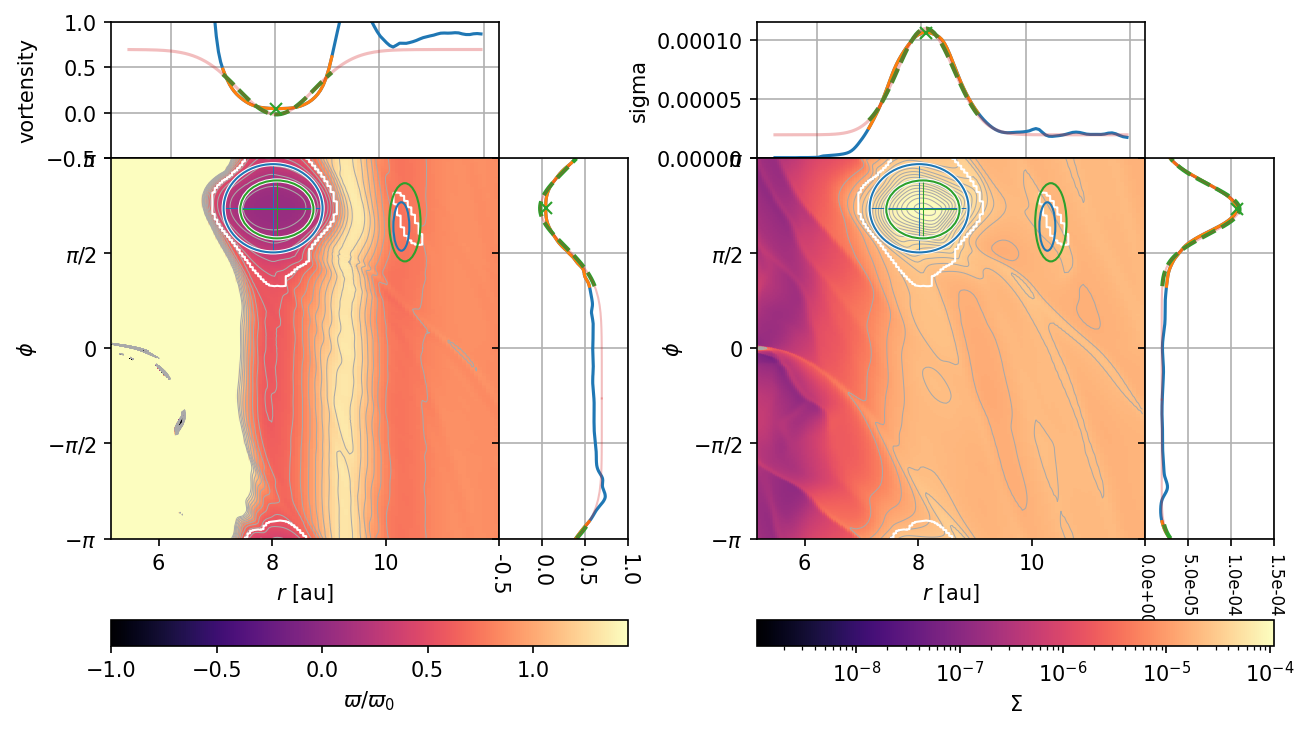

In [152]:
Rlims = [5.2, 12]
nl = np.argmin(np.abs(Xc[:,0]-Rlims[0]))
nr = np.argmin(np.abs(Xc[:,0]-Rlims[1]))
vd = vortector.Vortector(Xc[nl:nr,:], Yc[nl:nr,:], A[nl:nr,:], vortensity[nl:nr,:], Rho[nl:nr,:],
                         verbose=False, med=0.15, mear=np.inf,
                         levels=levels
                        )
# vd = vortector.Vortector(Xc, Yc, A, vortensity, Rho, Rho_background,
#                          [40,80], verbose=False, med=0.15, mear=np.inf,
#                          levels=levels
#                         )
%time vortices = vd.detect_vortex(include_mask=True, keep_internals=True)
for v in vortices:
    try:
        v["strength"] = np.exp(-v["vortensity_median"])*v["mass"]
        print("strength = {:.2e}, mass = {:.2e} , min vort = {:.3f}, sigma fit r_diff = {:.2e} phi_diff = {:.2e}".format(
            v['strength'],v['mass'],v['vortensity_min'],v["sigma_fit_r_reldiff"],v["sigma_fit_phi_reldiff"]))
        print(f"    contour diff 2D = {v['sigma_fit_contour_diff_2D']:.2e} , contour reldiff 2D = {v['sigma_fit_contour_reldiff_2D']:.2e}")
        print(f"    ellipse diff 2D = {v['sigma_fit_ellipse_diff_2D']:.2e} , ellipse reldiff 2D = {v['sigma_fit_ellipse_reldiff_2D']:.2e}")
        print(f"    area_ratio_ellipse_to_contour = {v['sigma_fit_area_ratio_ellipse_to_contour']:.2e}")
    except KeyError:
        pass
    
# vd.show_fit_overview_1D(0)
vd.show_fit_overview_2D()

In [153]:
vrad = simulation.fluids["gas"].get("2d", "velocity radial", Noutput).data.to_value("au/yr")
vrad = 0.5*(vrad[1:,:] + vrad[:-1,:])
vphi = simulation.fluids["gas"].get("2d", "velocity azimuthal", Noutput)
omega_frame = simulation.planets[0].get("omega frame").get_closest_to_time(vphi.get_time()).to("yr-1")
v_Frame = omega_frame*Xc*u.au
vphi = vphi.data.to_value("au/yr") + v_Frame.to_value("au/yr")
# vphi = vphi.data.to_value("au/yr")
vphi = np.pad(vphi, [[0,0],[0,1]], mode="wrap")
vphi = 0.5*(vphi[:,1:] + vphi[:,:-1])

vrad = vrad[nl:nr,:]
vphi = vphi[nl:nr,:]

2*np.pi*u.au/u.yr/np.sqrt(5.2)

<Quantity 2.75535903 AU / yr>

In [159]:
(astropy.constants.G*u.solMass).to_value("au3/yr2")

39.476926408897626

In [162]:
astropy.constants.G.to("au3 yr-2 solMass-1")

<Quantity 39.47692641 AU3 / (solMass yr2)>

In [171]:
def eccentricity_of_vortex(r, phi, area, rho, vrad, vphi, mask=None):

    #mass of each cell
    mass = rho * area

    #velocities in cartesian for each cell
    vx = vrad*np.cos(phi) - vphi*np.sin(phi)
    vy = vrad*np.sin(phi) + vphi*np.cos(phi)
    
    #cartesian coordinates
    x  = r * np.cos(phi)
    y  = r * np.sin(phi)

    #specific angular momentum and speed squared
    h2  = (x*vy - y*vx)**2
    v2  = vx*vx + vy*vy

    #smj axis from energy
    mu = (astropy.constants.G*u.solMass).to_value("au3/yr2")
    eng = 0.5*v2 - mu/r
    a   = -0.5*mu/eng
    
    #eccentricity
    ecc = np.sqrt(1.0-h2/(mu*a))
    
    #weight by mass, calculate weighted eccentricity of each cell
    if mask is None:
        mask = np.ones(mass.shape, dtype=bool)
        
    mass = mass[mask]
    a = a[mask]
    ecc = ecc[mask]
    
    total_mass = np.sum(mass)
    
    weighted_a = np.sum(a*mass)/total_mass
    weighted_ecc = np.sum(ecc*mass)/total_mass

    return {"a" : weighted_a, "e" : weighted_ecc}

In [173]:
eccentricity_of_vortex(vd.Xc, vd.Yc, vd.Area, vd.SurfaceDensity, vrad, vphi)

{'a': 9.528580184887595, 'e': 0.013720555775139273}

In [174]:
eccentricity_of_vortex(vd.Xc, vd.Yc, vd.Area, vd.SurfaceDensity, vrad, vphi, mask=vd.vortices[0]["mask"])

{'a': 8.208406271102724, 'e': 0.018638957260289496}

In [175]:
r0 = vd.vortices[0]["sigma_fit_2D_r0"]
hr = np.sqrt(2*np.log(2))*vd.vortices[0]["sigma_fit_2D_sigma_r"]
phi0 = vd.vortices[0]["sigma_fit_2D_phi0"]
hphi = np.sqrt(2*np.log(2))*vd.vortices[0]["sigma_fit_2D_sigma_phi"]
ellipse_mask = ((vd.Xc - r0)/hr)**2 + ((vd.Yc - phi0)/hphi)**2 <= 1
eccentricity_of_vortex(vd.Xc, vd.Yc, vd.Area, vd.SurfaceDensity, vrad, vphi, mask=ellipse_mask)

{'a': 8.200506744585981, 'e': 0.017012190862466324}